In [167]:
from lenstronomy.LightModel.light_model import LightModel
import numpy as np
import galsim

# For consistency, the exposure time should be equal to one of the exposure times in the MA tables
# since romanisim will use the MA table values to calculate per-second flux.
exposure_time = 188.48 # seconds
pixel_scale = 0.11

model = LightModel(["SERSIC"])
kwargs_model = [{"amp": 10, "R_sersic": 1.1, "n_sersic": 1.3}]

num_pix = 100
x = np.tile(np.linspace(-5, 5, num_pix), num_pix)
y = np.repeat(np.linspace(-5, 5, num_pix), num_pix)

image = model.surface_brightness(x, y, kwargs_model).reshape((num_pix, num_pix))
image = galsim.Image(array=np.array(image*exposure_time, dtype=int), scale=pixel_scale, xmin=0, ymin=0)

In [168]:
detector = 4                        # SCA detector number
detector_position = (2000, 2000)    # pixel position on detector, see docstring for default_romanisim_params() below
bandpass = "F106"

In [169]:
from romanisim.l1 import make_l1
from romanisim.image import make_l2, gather_reference_data, make_asdf
from romanisim import parameters, util, ris_make_utils, wcs
import roman_datamodels
import roman_datamodels.maker_utils as maker_utils


In [170]:
"""
# Lists out the exposure times for each resultant in each MA table. Taken from
# https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/observing-with-the-wfi-in-imaging-mode/wfi-multiaccum-tables
ACCUMULATED_EXPOSURE_TIMES = {
    4: [3.16247, 6.32494, 12.64988, 28.46223, 53.762, 79.06176, 104.36152, 135.98622, 139.14869], # MA table 4
    5: [3.16247, 6.32494, 12.64988, 31.6247, 50.59953, 69.57435, 88.54917, 107.52399, 132.82375, 164.44846, 196.07316, 199.23563], # MA table 5
    6: [3.16247, 6.32494, 12.64988, 31.6247, 50.59953, 69.57435, 94.87411, 120.17387, 145.47364, 170.7734, 196.07316, 227.69786, 259.32257, 290.94727, 294.10974], # MA table 6
    7: [3.16247, 6.32494, 12.64988, 37.94964, 63.24941, 94.87411, 126.49881, 164.44846, 202.3981, 240.34775, 278.29739, 316.24703, 354.19668, 392.14632, 395.30879], # MA table 7
    8: [3.16247, 6.32494, 12.64988, 37.94964, 66.41188, 98.03658, 135.98622, 186.58575, 237.18527, 287.7848, 338.38433, 388.98385, 439.58338, 490.1829, 493.34537], # MA table 8
    9: [3.16247, 6.32494, 12.64988, 37.94964, 63.24941, 94.87411, 132.82375, 183.42328, 234.0228, 284.62233, 335.22185, 385.82138, 487.02043, 588.21948, 591.38195], # MA table 9
    10: [3.16247, 6.32494, 12.64988, 37.94964, 75.89929, 126.49881, 177.09834, 227.69786, 278.29739, 328.89691, 430.09596, 531.29502, 632.49407, 733.69312, 736.85559], # MA table 10
    11: [3.16247, 6.32494, 12.64988, 63.24941, 113.84893, 164.448469, 265.647518, 366.846563, 468.045618, 569.244663, 670.443718, 771.642764, 872.841819, 974.040864, 977.20333] # MA table 11
}
"""

# Lists out the exposure times for each resultant in each MA table
# NOTE: romanisim currently uses different exposure time values than the ones listed above.
# The ones listed above have ~3.16 seconds per science read, whereas romanisim uses 3.04 seconds per science read
# See code for romanisim.util.add_more_metadata() to see how exposure times are calculated from the read pattern
# I reproduce the calculation here
ACCUMULATED_EXPOSURE_TIMES = {}
read_time = parameters.read_time

for ma_table_number in range(4, 12):
    ACCUMULATED_EXPOSURE_TIMES[ma_table_number] = []

    for resultant_number in range(len(parameters.read_pattern[ma_table_number])):
        ACCUMULATED_EXPOSURE_TIMES[ma_table_number] += [read_time * parameters.read_pattern[ma_table_number][resultant_number][-1]]
        
    print(f"{ma_table_number}:", ACCUMULATED_EXPOSURE_TIMES[ma_table_number])

4: [3.04, 6.08, 12.16, 27.36, 51.68, 76.0, 100.32000000000001, 124.64, 127.68]
5: [3.04, 6.08, 12.16, 30.4, 48.64, 66.88, 85.12, 103.36, 127.68, 152.0, 182.4, 185.44]
6: [3.04, 6.08, 12.16, 30.4, 48.64, 66.88, 88.16, 112.48, 136.8, 161.12, 185.44, 215.84, 246.24, 276.64, 279.68]
7: [3.04, 6.08, 12.16, 36.480000000000004, 60.8, 91.2, 121.6, 152.0, 188.48, 224.96, 261.44, 297.92, 334.4, 370.88, 373.92]
8: [3.04, 6.08, 12.16, 36.480000000000004, 60.8, 91.2, 127.68, 176.32, 224.96, 273.6, 322.24, 370.88, 419.52, 468.16, 471.2]
9: [3.04, 6.08, 12.16, 36.480000000000004, 60.8, 97.28, 133.76, 170.24, 218.88, 267.52, 316.16, 364.8, 462.08, 559.36, 562.4]
10: [3.04, 6.08, 12.16, 36.480000000000004, 72.96000000000001, 121.6, 170.24, 218.88, 267.52, 316.16, 413.44, 510.72, 608.0, 705.28, 708.32]
11: [3.04, 6.08, 12.16, 60.8, 109.44, 158.08, 255.36, 352.64, 449.92, 547.2, 644.48, 741.76, 839.04, 936.32, 939.36]


In [171]:
def select_MA_table_number(exposure_time):
    """Selects the appropriate MA table number and truncation based off of exposure time.
    This function assumes HLWAS detector. See the following link for more details.
    https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/observing-with-the-wfi-in-imaging-mode/wfi-multiaccum-tables

    Args:
        exposure_time: float, exposure time in seconds. Should be equal to one of the values in the
            ACCUMULATED_EXPOSURE_TIMES

    Returns:
        tuple(int, int), the MA table number used to select the corresponding read pattern for the detector as well as
            the truncation index for this read pattern so that only resultants up to given exposure time are included
    """

    # Select MA table number based off of exposure time
    for key, value in ACCUMULATED_EXPOSURE_TIMES.items():
        if exposure_time in value:
            ma_table_number = key
            truncate = value.index(exposure_time) + 1
            return ma_table_number, truncate

    raise ValueError("Exposure time must be equal to one of the exposure times in the MA tables")

In [172]:
def compile_metadata(bandpass, detector, exposure_time, date="2024-07-07T00:00:00"):
    """Compiles the metadata required to apply detector effects.

    Args:
        bandpass: string specifying the imaging band ("F062", "F106", etc)
        detector: int specifying the SCA detector number
        exposure_time: float specifying the exposure time in seconds
        date: string specifying the start date of observation

    Returns:
        dict. See e.g. romanisim.parameters.default_parameters_dictionary.
        Used to generate romanisim parameters for applying detector effects
    """
    ma_table_number, truncate = select_MA_table_number(exposure_time=exposure_time)

    # TODO: Don't know what scale_factor is for; something to do with velocity aberration effects
    metadata = ris_make_utils.set_metadata(meta=None, date=date, bandpass=bandpass, sca=detector,
                 ma_table_number=ma_table_number, truncate=truncate, scale_factor=1.0)
    
    return metadata

In [173]:
metadata = compile_metadata(bandpass=bandpass, detector=detector, exposure_time=exposure_time)

In [174]:
def default_romanisim_params(metadata, detector_position, image_size):
    """Generates romanisim parameters for applying detector effects,
    based off of the band, detector, detector position, exposure time and other data
    stored in metadata. This function is a copy-paste of the first several lines of
    romanisim.image.simulate().

    Args:
        metadata: dict. See e.g. romanisim.parameters.default_parameters_dictionary.
            This can be generated using romanisim.ris_make_utils.set_metadata()
        detector_position: tuple(int, int), pixel on the detector with which to apply
            e.g. nonlinearity effects
        image_size: int, size of the image.

    Returns:
        tuple(dict, dict, dict), keyword arguments used to apply l1 and l2 detector effects
        to a synthetic image and the updated metadata

    Notes:
        Certain detector effects (e.g. non-linearity) require fetching data from reference files
        on the CRDS server. This may require setting environment variables. See
        https://roman-crds.stsci.edu/docs/cmdline_bestrefs/ for more details.
    """
    meta = maker_utils.mk_common_meta()
    meta["photometry"] = maker_utils.mk_photometry()
    meta['wcs'] = None

    for key in parameters.default_parameters_dictionary.keys():
        meta[key].update(parameters.default_parameters_dictionary[key])

    for key in metadata.keys():
        meta[key].update(metadata[key])

    util.add_more_metadata(meta)

    # Create Image model to track validation
    image_node = maker_utils.mk_level2_image()
    image_node['meta'] = meta
    image_mod = roman_datamodels.datamodels.ImageModel(image_node)

    read_pattern = metadata['exposure'].get(
        'read_pattern',
        parameters.read_pattern[metadata['exposure']['ma_table_number']])

    # Downloads reference files from a server
    refdata = gather_reference_data(image_mod, usecrds=True)

    # The reference data contains 4088x4088 arrays
    # Since we are applying detector effects to a smaller image, these 4088x4088 arrays
    # need to be truncated based off of image size and detector position
    i = int(detector_position[0] - image_size/2)
    j = int(detector_position[1] - image_size/2)

    refdata['inverselinearity'].coeffs = refdata['inverselinearity'].coeffs[:, i:i+100, j:j+100]
    refdata['inverselinearity'].dq = refdata['inverselinearity'].dq[i:i+100, j:j+100]
    refdata['linearity'].coeffs = refdata['linearity'].coeffs[:, i:i+100, j:j+100]
    refdata['linearity'].dq = refdata['linearity'].dq[i:i+100, j:j+100]
    refdata['flat'] = refdata['flat'][i:i+100, j:j+100]

    # Bundle up the detector effect kwargs
    l1_effects_kwargs = {
        "read_pattern": read_pattern,
        "read_noise": refdata['readnoise'],
        "pedestal_extra_noise": parameters.pedestal_extra_noise,
        "gain": refdata['gain'],
        "inv_linearity": refdata['inverselinearity'],
        "crparam": {}, # None to exclude cosmic ray effects, empty dict to include using defaults
        "persistence": None, # Not included
        "tstart": image_mod.meta.exposure.start_time,
        "saturation": refdata['saturation'],
    }
    l2_effects_kwargs = {
        "read_pattern": read_pattern,
        "read_noise": refdata['readnoise'],
        "gain": refdata['gain'],
        "darkrate": refdata['dark'],
        "linearity": refdata['linearity'],
        "flat": refdata['flat']
    }
    return l1_effects_kwargs, l2_effects_kwargs, meta


In [ ]:
l1_effects_kwargs, l2_effects_kwargs, updated_metadata = default_romanisim_params(metadata=metadata, detector_position=detector_position, image_size=image.array[0].size)
rng = None
seed = None

# Make sure that the exposure time used by romanisim is the same exposure time we passed into galsim.Image
assert updated_metadata['exposure']['exposure_time'] == exposure_time

In [176]:
l1, l1dq = make_l1(image, rng=rng, seed=seed, **l1_effects_kwargs)

2025-06-03 12:22:57 INFO     Apportioning electrons to resultants...
2025-06-03 12:22:57 WARNING  No RNG set, constructing a new default RNG from default seed.
2025-06-03 12:22:59 INFO     Adding IPC...
2025-06-03 12:22:59 INFO     Adding read noise...
2025-06-03 12:22:59 WARNING  No RNG set, constructing a new default RNG from default seed.


In [177]:
# These have units of DN/s. The conversion from DN to electrons can be accessed with l2_effects_kwargs['gain']
l2_image, var_rnoise, var_poisson = make_l2(l1, **l2_effects_kwargs, dq=l1dq)

# NOTE: I don't know what this does but it's done in romanisim.image.simulate() so I'll do it here too
# This is later passed into make_asdf()
l2dq = np.bitwise_or.reduce(l1dq, axis=0)

2025-06-03 12:22:59 INFO     Fitting ramps.


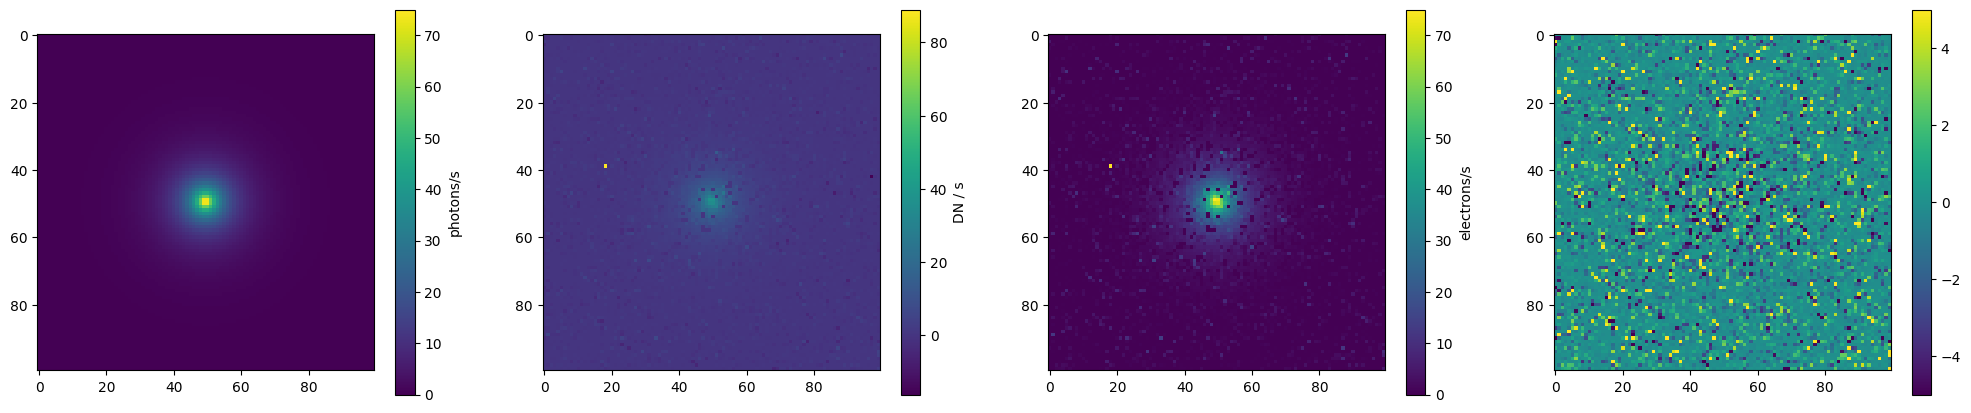

In [178]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 4, figsize=(25, 5))
im1 = ax[0].imshow(image.array / exposure_time, vmin=0, vmax=75)
im2 = ax[1].imshow(l2_image.value)
im3 = ax[2].imshow(l2_image.value * l2_effects_kwargs['gain'].value, vmin=0, vmax=75)
im4 = ax[3].imshow(l2_image.value * l2_effects_kwargs['gain'].value - image.array / exposure_time, vmin=-5, vmax=5)

plt.colorbar(im1, ax=ax[0], label=f'photons/s') # synthetic image
plt.colorbar(im2, ax=ax[1], label=f'{l2_image.unit}') # apply effects to synthetic image, units of DN/s
plt.colorbar(im3, ax=ax[2], label=f'electrons/s') # same as above but converted to electrons/s
plt.colorbar(im4, ax=ax[3]) # difference between new and original image
plt.show()

In [179]:
# NOTE: Not sure what this does but it's required for make_asdf. This is done in romanisim.image.simulate_counts(),
# which is eventually passed into make_asdf() in romanisim.image.simulate()
imwcs = wcs.get_wcs(updated_metadata, usecrds=True)

# file path to store asdf
filepath = r"/home/ahuang314/Notebooks/test.asdf"

# NOTE: This function lacks documentation in the romanisim source code and readthedocs
im, extras = make_asdf(l2_image, var_rnoise, var_poisson, metadata=updated_metadata, filepath=None, persistence=None, dq=l2dq, imwcs=imwcs, gain=l2_effects_kwargs['gain'])